# Find OpToxs Blooms! (Australia)

## Contents

1. [Setup](#1.-Setup)
2. [NASA Earthdata Authentication](#2.-NASA-Earthdata-Authentication)

## 1. Setup

We begin by importing the packages used in this notebook.

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import h5netcdf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyinterp.backends.xarray  # Module that handles the filling of undefined values. (interpolating library)
import pyinterp.fill
import seaborn as sns
import xarray as xr
from matplotlib.patches import Rectangle

[back to top](#Contents)

## 2. NASA Earthdata Authentication

Next, we authenticate using our Earthdata Login
credentials. Authentication is not needed to search publicly
available collections in Earthdata, but is always needed to access
data. We can use the `login` method from the `earthaccess`
package. This will create an authenticated session when we provide a
valid Earthdata Login username and password. The `earthaccess`
package will search for credentials defined by **environmental
variables** or within a **.netrc** file saved in the home
directory. If credentials are not found, an interactive prompt will
allow you to input credentials.

<div class="alert alert-info" role="alert">

The `persist=True` argument ensures any discovered credentials are
stored in a `.netrc` file, so the argument is not necessary (but
it's also harmless) for subsequent calls to `earthaccess.login`.

</div>

In [2]:
auth = earthaccess.login(persist=True)

[back to top](#Contents)

## 3. Search for Data

Collections on NASA Earthdata are discovered with the
`search_datasets` function, which accepts an `instrument` filter as an
easy way to get started. Each of the items in the list of
collections returned has a "short-name".

In [3]:
results = earthaccess.search_datasets(instrument="oci")

In [4]:
for item in results:
    summary = item.summary()
    print(summary["short-name"])

PACE_OCI_L1B_SCI
PACE_OCI_L2_AOP
PACE_OCI_L2_BGC_NRT
PACE_OCI_L0_SCI
PACE_OCI_L1A_SCI
PACE_OCI_L1C_SCI
PACE_OCI_L2_AOP_NRT
PACE_OCI_L2_BGC
PACE_OCI_L2_CLOUD
PACE_OCI_L2_CLOUD_MASK
PACE_OCI_L2_CLOUD_MASK_NRT
PACE_OCI_L2_CLOUD_NRT
PACE_OCI_L2_IOP
PACE_OCI_L2_IOP_NRT
PACE_OCI_L2_LANDVI
PACE_OCI_L2_LANDVI_NRT
PACE_OCI_L2_PAR
PACE_OCI_L2_PAR_NRT
PACE_OCI_L2_SFREFL
PACE_OCI_L2_SFREFL_NRT
PACE_OCI_L3B_AVW
PACE_OCI_L3B_AVW_NRT
PACE_OCI_L3B_CARBON
PACE_OCI_L3B_CARBON_NRT
PACE_OCI_L3B_CHL
PACE_OCI_L3B_CHL_NRT
PACE_OCI_L3B_FLH
PACE_OCI_L3B_FLH_NRT
PACE_OCI_L3B_IOP
PACE_OCI_L3B_IOP_NRT
PACE_OCI_L3B_KD
PACE_OCI_L3B_KD_NRT
PACE_OCI_L3B_LANDVI
PACE_OCI_L3B_LANDVI_NRT
PACE_OCI_L3B_PAR
PACE_OCI_L3B_PAR_NRT
PACE_OCI_L3B_POC
PACE_OCI_L3B_POC_NRT
PACE_OCI_L3B_RRS
PACE_OCI_L3B_RRS_NRT
PACE_OCI_L3B_SFREFL
PACE_OCI_L3B_SFREFL_NRT
PACE_OCI_L3M_AVW
PACE_OCI_L3M_AVW_NRT
PACE_OCI_L3M_CARBON
PACE_OCI_L3M_CARBON_NRT
PACE_OCI_L3M_CHL
PACE_OCI_L3M_CHL_NRT
PACE_OCI_L3M_CLOUD
PACE_OCI_L3M_CLOUD_NRT
PACE_OCI_L3M_FLH
PA

In [3]:
tspan = ("2025-01-01", "2025-08-04") #time span

results1 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL",
    temporal=tspan,
#    bounding_box=bbox, #bbox and clouds are just for L2 producs
#    cloud_cover=clouds,
    granule_name="*.DAY.*4km.*"
)

results2 = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CHL_NRT",
    temporal=tspan,
#    bounding_box=bbox,
#    cloud_cover=clouds,
    granule_name="*.DAY.*4km.*"
)

results = results1 + results2
len(results)

335

In [4]:
results[0]

Collection: {'ShortName': 'PACE_OCI_L3M_CHL', 'Version': '3.0'}
Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'NorthBoundingCoordinate': 90, 'EastBoundingCoordinate': 180, 'SouthBoundingCoordinate': -90, 'WestBoundingCoordinate': -180}]}}}
Temporal coverage: {'RangeDateTime': {'EndingDateTime': '2025-01-01T23:59:59Z', 'BeginningDateTime': '2025-01-01T00:00:00Z'}}
Size(MB): 8.29880142211914
Data: ['https://obdaac-tea.earthdatacloud.nasa.gov/ob-cumulus-prod-public/PACE_OCI.20250101.L3m.DAY.CHL.V3_0.chlor_a.4km.nc']

In [5]:
paths = earthaccess.open(results) #the .open function is to 'stream' the data (4/4 for the 4 granules we searched for before)

QUEUEING TASKS | :   0%|          | 0/335 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/335 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/335 [00:00<?, ?it/s]

The `paths` list contains references to files on a remote filesystem. The ob-cumulus-prod-public is the S3 Bucket in AWS us-west-2 region.

We merge all the variables from the different groups together using: open_mfdataset (multiple frames)

In [6]:
## ChatGPT - for weekly

import re
from datetime import datetime
from collections import defaultdict

# Step 1: Group paths by ISO week (e.g. '2025-W09')
paths_by_week = defaultdict(list)

for path in paths:
    match = re.search(r'(\d{8})', str(path))  # Match full date (YYYYMMDD)
    if match:
        date_str = match.group(1)
        date_obj = datetime.strptime(date_str, "%Y%m%d")
        week_id = f"{date_obj.isocalendar().year}-W{date_obj.isocalendar().week:02d}"
        paths_by_week[week_id].append(path)

# Step 2: Load each group into a dataset with real dates
datasets_by_week = {}

for week_id, file_group in paths_by_week.items():
    # Extract actual dates from filenames
    dates = [
        datetime.strptime(re.search(r'\d{8}', str(p)).group(), "%Y%m%d")
        for p in file_group
    ]

    # Sort files and dates together
    file_date_pairs = sorted(zip(dates, file_group), key=lambda x: x[0])
    sorted_dates, sorted_paths = zip(*file_date_pairs)

    # Load the dataset and assign the correct dates
    ds = xr.open_mfdataset(
        sorted_paths,
        combine="nested",
        concat_dim="date"
    ).assign_coords(date=("date", pd.to_datetime(sorted_dates)))

    datasets_by_week[week_id] = ds


In [7]:
datasets_by_week['2025-W18'] #the last week (use: datasets_by_month['202501'] for monthly)

<xarray.Dataset> Size: 2GB
Dimensions:  (date: 12, lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * date     (date) datetime64[ns] 96B 2025-04-28 2025-04-28 ... 2025-05-04
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a  (date, lat, lon) float32 2GB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    palette  (date, rgb, eightbitcolor) uint8 9kB dask.array<chunksize=(1, 3, 256), meta=np.ndarray>
Attributes: (12/64)
    product_name:                      PACE_OCI.20250428.L3m.DAY.CHL.V3_0.chl...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CHL/3.0
    keywords:                          Earth Science > Oceans > Ocean Chemist...
    keywords_vocabulary:               NASA Global Change Master Directory (G...
    data_bins:                         3188073
    data_minimum:                      0.0009999999
    data_maximum:                      99.94991

In [8]:
datasets_by_week['2025-W18']["chlor_a"].mean('date')

<xarray.DataArray 'chlor_a' (lat: 4320, lon: 8640)> Size: 149MB
dask.array<mean_agg-aggregate, shape=(4320, 8640), dtype=float32, chunksize=(512, 1024), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 17kB 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon      (lon) float32 35kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0

In [9]:
sliced_ds = datasets_by_week['2025-W18']["chlor_a"].mean('date').sel(lat=slice(-32.7, -36), lon=slice(135.5, 138.6), ) #slice must be big small, small big 

In [10]:
sliced_ds

<xarray.DataArray 'chlor_a' (lat: 79, lon: 74)> Size: 23kB
dask.array<getitem, shape=(79, 74), dtype=float32, chunksize=(79, 74), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 316B -32.73 -32.77 -32.81 ... -35.9 -35.94 -35.98
  * lon      (lon) float32 296B 135.5 135.6 135.6 135.6 ... 138.5 138.5 138.6

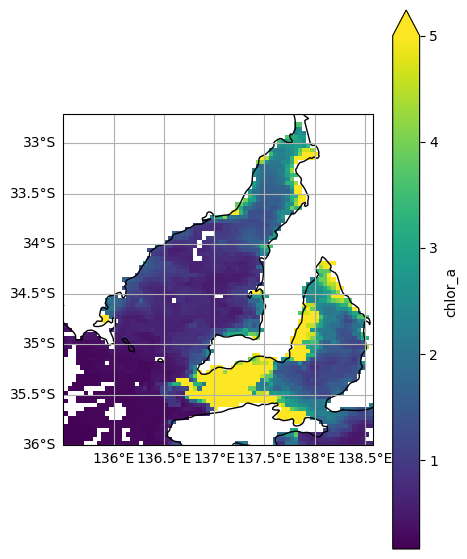

In [11]:
#sliced_ds = datasets_by_week['2025-W18']["chlor_a"].mean('date').sel(lat=slice(-32.7, -36), lon=slice(135.5, 138.6), ) #slice must be big small, small big 
fig = plt.figure(figsize = (5,7))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels={"left": "y", "bottom": "x"})
plot = sliced_ds.plot(x='lon', y='lat', cmap="viridis", vmax=5)

In [12]:
import imageio
import os

# 1. Weeks
weeks = [f"2025-W{str(i).zfill(2)}" for i in range(1, 32)]

# 2. Region
lat_slice = slice(-32.7, -36)
lon_slice = slice(135.6, 138.7)

# 3. Output folder
os.makedirs("gif_frames", exist_ok=True)
filenames = []

# 4. Fixed color scale (linear)
vmin = 0
vmax = 12

# 5. Loop through weeks
for week in weeks:
    if week not in datasets_by_week:
        print(f"Skipping missing week: {week}")
        continue

    sliced_ds = datasets_by_week[week]["chlor_a"].mean('date').sel(lat=lat_slice, lon=lon_slice)

    fig = plt.figure(figsize=(6, 7))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent([lon_slice.start, lon_slice.stop, lat_slice.start, lat_slice.stop], crs=ccrs.PlateCarree())
    ax.coastlines()
    ax.gridlines(draw_labels={"left": "y", "bottom": "x"})

    # 🌟 Plot a star for Adelaide
    ax.plot(
        138.6007, -34.9285,
        marker='*',
        color='b',
        markersize=12,
        transform=ccrs.PlateCarree(),
        label='Adelaide'
    )

    # Plot with fixed linear scale
    im = ax.pcolormesh(
        sliced_ds['lon'],
        sliced_ds['lat'],
        sliced_ds.values,
        cmap='viridis',
        vmin=vmin,
        vmax=vmax,
        transform=ccrs.PlateCarree()
    )

    # Fixed-position colorbar
    cbar = plt.colorbar(im, ax=ax, orientation='vertical', shrink=0.8, pad=0.05)
    cbar.set_label("Chlorophyll-a [mg/m³]")

    ax.set_title(f"Chlorophyll-a - Week {week}")

    # Save frame
    filename = f"gif_frames/frame_{week}.png"
    plt.savefig(filename, bbox_inches='tight', dpi=100)
    filenames.append(filename)
    plt.close()

# 6. Create the GIF
with imageio.get_writer('chlorophyll_weekly.gif', mode='I', duration=500) as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF saved as 'chlorophyll_weekly.gif'")


/tmp/ipykernel_1715/3101022178.py:69: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


GIF saved as 'chlorophyll_weekly.gif'


In [13]:
from IPython.display import display, HTML

display(HTML('<img src="chlorophyll_weekly.gif">'))
